### Imports

In [43]:
from matplotlib_venn import venn2 
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from utils.utils import *

import hdbscan
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import sys

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.48 ms (started: 2023-05-26 17:46:14 -05:00)


### Parameters

In [44]:
import json
  
# Opening JSON file
file = open("parameters.json")
params = json.load(file)

dir = os.path.dirname(os.getcwd())
print(dir)

method = params["method"][params["method_idx"]]
print("Method:\t\t", method)

group = params["group"][params["group_idx"]]
print("Group:\t\t", group)

subgroups = [str(k + 1) for k in range(group[1])]
print("Subgroup:\t", subgroups)

dimensions = params["dimensions"]
dimension = dimensions[0]
print("Dimensions:\t", dimensions)

/home/ealvarez/Project/GNN_Filter
Method:		 vgae
Group:		 ['pck1^', 2]
Subgroup:	 ['1', '2']
Dimensions:	 [3]
time: 2.04 ms (started: 2023-05-26 17:46:14 -05:00)


### Read graphs

In [45]:
# Greedy ANOVA
df_edge_embeddings_join_filter_count_weight_std_avg_anova = pd.read_csv("{}/output_greedy/edges_filter_weight_std_avg_anova/greedy_{}_edge-filter-weight-std-avg-anova.csv".format(dir, group[0]))
df_edge_embeddings_join_filter_count_weight_std_avg_anova

G1 = nx.from_pandas_edgelist(df_edge_embeddings_join_filter_count_weight_std_avg_anova, "source", "target", edge_attr=["weight"])
graph_detail(G1)

Num. nodes: 907
Num. edges: 48440

time: 105 ms (started: 2023-05-26 17:46:14 -05:00)


In [46]:
# Greedy std
df_edge_embeddings_join_filter_count_weight_std_avg = pd.read_csv("{}/output_greedy/edges_filter_weight_std_avg/greedy_{}_edge-filter-weight-std-avg.csv".format(dir, group[0]))
df_edge_embeddings_join_filter_count_weight_std_avg

G1_ = nx.from_pandas_edgelist(df_edge_embeddings_join_filter_count_weight_std_avg, "source", "target", edge_attr=["weight"])
graph_detail(G1_)

Num. nodes: 5677
Num. edges: 732148

time: 1.51 s (started: 2023-05-26 17:46:14 -05:00)


In [47]:
# GNN method
df_edge_embeddings_join_filter_count_weight_std_avg = pd.read_csv("{}/output_edges/edges_filter_weight_std_avg/{}_{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, method, group[0], dimension, "L2"))
df_edge_embeddings_join_filter_count_weight_std_avg

G2 = nx.from_pandas_edgelist(df_edge_embeddings_join_filter_count_weight_std_avg, "source", "target", edge_attr=["weight"])
graph_detail(G2)

Num. nodes: 5261
Num. edges: 426354

time: 912 ms (started: 2023-05-26 17:46:16 -05:00)


### Get common edges

Nodes:
Greedy & vgae: 5261
Greedy - vgae: 416
vgae - Greedy: 0
Edges:
Greedy & vgae: 426354
Greedy - vgae: 305794
vgae - Greedy: 0


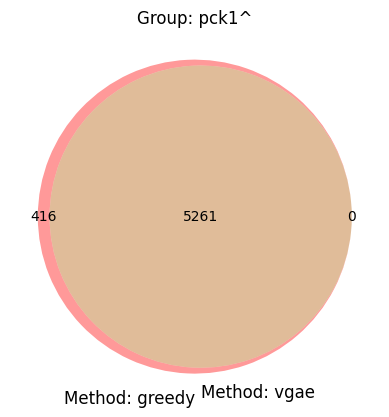

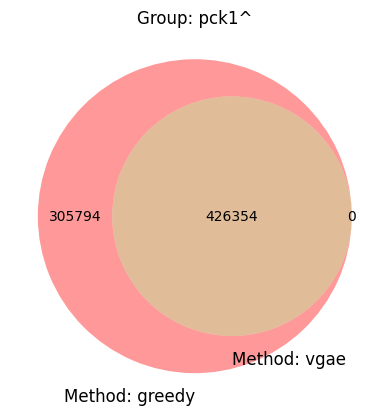

time: 1.63 s (started: 2023-05-26 17:46:16 -05:00)


In [48]:
common_nodes_edges = get_common_nodes_edges(G1_, G2, "Greedy", method)

venn2(subsets = (len(common_nodes_edges[1][0]), len(common_nodes_edges[2][0]), len(common_nodes_edges[0][0])), set_labels=("Method: greedy", "Method: {}".format(method)))
plt.title("Group: {}".format(group[0]))
plt.show()

venn2(subsets = (len(common_nodes_edges[1][1]), len(common_nodes_edges[2][1]), len(common_nodes_edges[0][1])), set_labels=("Method: greedy", "Method: {}".format(method)))
plt.title("Group: {}".format(group[0]))
plt.show()

Nodes:
Greedy & vgae: 880
Greedy - vgae: 27
vgae - Greedy: 4381
Edges:
Greedy & vgae: 38353
Greedy - vgae: 10087
vgae - Greedy: 388001


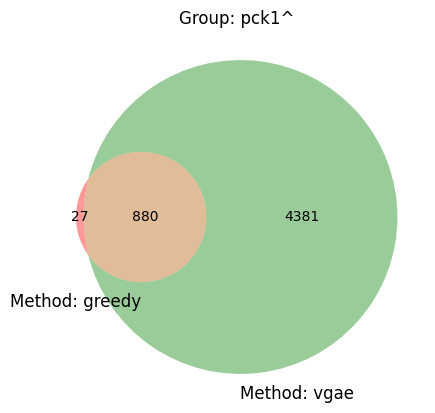

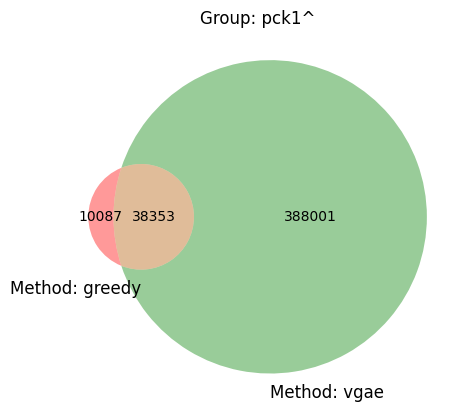

time: 751 ms (started: 2023-05-26 17:46:18 -05:00)


In [49]:
common_nodes_edges = get_common_nodes_edges(G1, G2, "Greedy", method)

venn2(subsets = (len(common_nodes_edges[1][0]), len(common_nodes_edges[2][0]), len(common_nodes_edges[0][0])), set_labels=("Method: greedy", "Method: {}".format(method)))
plt.title("Group: {}".format(group[0]))
plt.show()

venn2(subsets = (len(common_nodes_edges[1][1]), len(common_nodes_edges[2][1]), len(common_nodes_edges[0][1])), set_labels=("Method: greedy", "Method: {}".format(method)))
plt.title("Group: {}".format(group[0]))
plt.show()